[View in Colaboratory](https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/4_5_simple_multi_perceptron_keras_implementation.ipynb)

In [2]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# why not numpy?
import numpy as np
import zipfile
from sklearn.metrics import roc_auc_score


from glob import glob # useless
from tqdm import tqdm # maybe useful
import pickle # very useful
from collections import Counter # I'm a counter
from mvpa2.mappers.fx import mean_group_sample # pymvpa
from mvpa2.generators.partition import NFoldPartitioner # pymvpa
from mvpa2.base.node import ChainNode # pymvpa
from mvpa2.generators.resampling import Balancer # pymvpa
from mvpa2.generators.base import Sifter # pymvpa
from mvpa2.mappers.base import Mapper # pymvpa
from keras.layers import Dense,Dropout,BatchNormalization
from keras.layers import Input, AveragePooling3D,Reshape
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import GaussianNoise # add noise to our data
from keras.layers import Flatten,Dense,LeakyReLU,Conv3DTranspose
from keras.models import Model
import keras
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
from sklearn import metrics
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

data_id = 'https://drive.google.com/open?id=1sMQh_8qhCwN7N1yM8mTEBT9m8q7l_0iv'.split('id=')[-1]
zip_import = drive.CreateFile({'id':data_id})
zip_import.GetContentFile('{}'.format('all_bin.pkl'))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.10-1.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Requirement already up-to-date: pymvpa2 in /usr/local/lib/python2.7/dist-packages (2.6.5)
Requirement already up-to-date: seaborn in /usr/local/lib/python2.7/dist-packages (0.9.0)


Using TensorFlow backend.


# Read condition

## Experiment:

### Subjects in the sanner, and were instructed to read the word repeatedly as it was present. The words can be divided into 2 semantic categories: living animals and non-living tools

## words:

'llave', 'lapiz', 'tijera', 'aguja', 'pinza', 'sierra', 'clavo',
'pincel', 'alicate', 'tuerca', 'navaja', 'cepillo', 'taladro',
'soplete', 'tornillo', 'cuchara', 'martillo', 'cuchillo', 'tigre',
'gallo', 'perro', 'oveja', 'cerdo', 'gorila', 'burro', 'yegua',
'ardilla', 'conejo', 'gallina', 'caballo', 'ballena', 'pantera',
'camello', 'tortuga', 'elefante', 'canguro'
<br />**can you divide them?**

In [0]:
dataset_ = pickle.load(open('all_bin.pkl','rb'))
dataset = dataset_[dataset_.sa.context == 'read']

In [4]:
print(dataset.summary())

Dataset: 1544x16130@float32, <sa: categories,chunks,context,id,targets,time_coords,time_indices,trials,words>, <fa: voxel_indices>, <a: imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>
stats: mean=8.95748e-10 std=0.993167 var=0.98638 min=-6.82599 max=6.5985

Counts of targets in each chunk:
  chunks\targets animal tool
                   ---   ---
        0          111   111
        2          110   111
        4          110   110
        6          108   115
        8          109   109
       10          108   110
       12          111   111

Summary for targets across chunks
  targets mean  std min max #chunks
  animal   110 1.18 108 111    7
   tool    111 1.77 109 115    7

Summary for chunks across targets
  chunks mean std min max #targets
    0     111  0  111 111     2
    2     110 0.5 110 111     2
    4     110  0  110 110     2
    6     112 3.5 108 115     2
    8     109  0  109 109     2
   10     109  1  108 110     2
   12     111  0  111 111     2
Sequence s

In [0]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import (classification_report,
                             matthews_corrcoef,
                             confusion_matrix,
                             f1_score,
                             log_loss)



In [0]:
# helper funtion
def get_blocks(dataset__,label_map):
    """
    # use ids, chunks,and labels to make unique blocks of the pre-average dataset, because I don't want to 
    # average the dataset until I actually want to, but at the same time, I want to balance the data for 
    # both the training and test set.
    
    Preparation for cross validation functions used in scit-kit learning
    """
    ids                 = dataset__.sa.id.astype(int)
    chunks              = dataset__.sa.chunks
    labels              = np.array([label_map[item] for item in dataset__.targets])[:,-1]
    sample_indecies     = np.arange(len(labels))
    blocks              = [np.array([ids[ids             == target],
                                     chunks[ids          == target], 
                                     labels[ids          == target],
                                     sample_indecies[ids == target]
                                     ]) for target in np.unique(ids)]
    block_labels        = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()
    return blocks,block_labels


In [0]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold         = roc_curve(target, predicted)
    i                           = np.arange(len(tpr)) 
    roc                         = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t                       = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [0]:
import keras
from keras.layers                                  import Conv3D,Dense,Dropout,BatchNormalization
from keras.layers                                  import Input, AveragePooling3D,MaxPooling3D,Conv2DTranspose
from keras.layers                                  import Flatten,LeakyReLU,UpSampling3D,ThresholdedReLU
from keras.layers                                  import GlobalAveragePooling3D,Permute,GlobalMaxPool2D
from keras.layers                                  import Conv2D,GlobalAveragePooling2D,UpSampling2D
from keras.layers                                  import AveragePooling2D,MaxPool2D,merge
from keras.layers                                  import GaussianNoise,GaussianDropout,SimpleRNN,GRU
#from keras.layers import ReLU
from keras.models                                  import Model,Sequential
from keras.layers.noise                            import AlphaDropout
from keras.callbacks                               import ModelCheckpoint,TensorBoard,EarlyStopping
from keras                                         import backend as K
from keras.layers                                  import Conv3DTranspose,Activation, Lambda,Multiply

In [0]:
class stacked_perceptron(object):
    """
    to construct stacked layers of dense-batchnormaization-activation-layers
    edit: batch normalization is no used due to activation SELU
    https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9
    https://arxiv.org/pdf/1706.02515.pdf
    """
    def __init__(self,
#                 inputs,
                 hidden_units, # number of neurons of the dense layer
                 layer_func                                 = Dense,
                 beta                                       = 1, # L1 regularization value
                 lamda                                      = 1,# L2 regularization, used exclusively in parameters regularization
                 dropout_func                               = AlphaDropout,# special drop out function: https://arxiv.org/pdf/1706.02515.pdf
                 dropout_rate                               = 0.2,# dropout rate
                 name                                       = [1,1,'encode'],# the way of naming the layers
                 kernel_regularizer                         = regularizers.l1_l2,# parameter regularization function: elatic
                 kernel_initializer                         ='he_normal',# initialize the parameter method
                 activation                                 = 'selu',# self normalizing NN
                 alpha                                      = 0.3, # not used
                 l1                                         = False, # default of not using L1 activation regularization
                 use_bias                                   = True,# defult of using bias terms in the dense layers
                 batch_normal                               = True,# defult of using batch normalization
                 ):
#        self.inputs = inputs
        self.layer_func                                     = layer_func
        self.hidden_units                                   = hidden_units
        self.kernel_regularizer                             = kernel_regularizer
        self.kernel_initializer                             = kernel_initializer
        self.beta                                           = beta
        self.lamda                                          = lamda
        self.dropout_func                                   = dropout_func
        self.dropout_rate                                   = dropout_rate
        self.name                                           = name
        self.activation                                     = activation
        self.alpha                                          = alpha
        self.l1                                             = l1
        self.use_bias                                       = use_bias
        self.batch_normal                                   = batch_normal
    def __call__(self,net):
        ####################### dense layer block ###################################################
        if self.l1: # if regularize the activation output
            net = self.layer_func(units                     = self.hidden_units,
                        use_bias                            = self.use_bias,
                        kernel_initializer                  = self.kernel_initializer,
                        kernel_regularizer                  = self.kernel_regularizer(1e-6,self.lamda),
                        activity_regularizer                = regularizers.l1(self.beta),
                        name                                = 'dense_layer{}_{}_{}'.format(self.name[0],
                                                                                           self.name[1],
                                                                                           self.name[2])
                        )(net)
        else:
            net = self.layer_func(units                     = self.hidden_units,
                        use_bias                            = True,
                        kernel_initializer                  = self.kernel_initializer,
                        kernel_regularizer                  = self.kernel_regularizer(1e-6,self.lamda),
#                        activity_regularizer = regularizers.l1(self.beta),
                        name                                = 'dense_layer{}_{}_{}'.format(self.name[0],
                                                                                           self.name[1],
                                                                                           self.name[2])
                        )(net)
        #################### end of dense layer block #################################################
        #################### batch normalization block ################################################
        if self.batch_normal:
            net = BatchNormalization(name                   = 'norm_layer{}_{}_{}'.format(self.name[0],
                                                                                          self.name[1]+1,
                                                                                          self.name[2]))(net)
        ################### end of batch normalization block ################################################
        ################### actiavtion block ##########################################################
        if type(self.activation) is not str:
            net = self.activation(name                      = 'activation_layer{}_{}_{}'.format(self.name[0],
                                                                                                self.name[1]+2, 
                                                                                                self.name[2]),
                                  alpha                     = self.alpha)(net)
        else:
            net = Activation(activation = self.activation,
                             name                           = 'activation_layer{}_{}_{}'.format(self.name[0],
                                                                                                self.name[1]+2, 
                                                                                                self.name[2]),
                              )(net)
        ################### end of activation block ######################################################
        ################### dropout layer block ##########################################################
        net = self.dropout_func(rate                        = self.dropout_rate,
                      name                                  = 'drop_layer{}_{}_{}'.format(self.name[0],
                                                                                          self.name[1]+3,
                                                                                          self.name[2]))(net)
        
        return net

In [0]:
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    """
    Make call back function lists for the keras models
    
    Inputs
    -------------------------
    model_name: directory of where we want to save the model and its name
    monitor: the criterion we used for saving or stopping the model
    mode: min --> lower the better, max --> higher the better
    verboser: printout the monitoring messages
    min_delta: minimum change for early stopping
    patience: temporal windows of the minimum change monitoring
    frequency: temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint: saving the best model
    EarlyStopping: early stoppi....
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          =monitor,# saving criterion
                                 save_best_only   =True,# save only the best model
                                 mode             =mode,# saving criterion
                                 period           =frequency,# frequency of check the update 
                                 verbose          =verbose# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          =monitor,
                                 min_delta        =min_delta,
                                 patience         =patience,
                                 verbose          =verbose, 
                                 mode             =mode,
                                 )
    return [checkPoint,earlyStop]

In [0]:
def clf(shape,
         beta               = 1,
         lamda              = 1,
         dropout_rate       = 0.,
         latent_dim         = 36,
         lr                 = 1e-3,
         decay              = 0,
         add_noise          = False,
         add_sparsity       = False,
         rho                = 0.02,
         sparse_beta        = 1,
         ):
    inputs                  = Input(shape                                   = (shape,),
                              batch_shape                                   = (None,shape),
                              name                                          = 'inputs',
                              dtype                                         = 'float32'
                              )
    ####################################### add noise to the inputs #################################
    ############################ Gaussian noise #####################################################
    if add_noise:
        inputs_            = GaussianNoise(stddev = 1)(inputs)
        encode_            = inputs_
    else:
        encode_            = inputs
    latent_space           = stacked_perceptron(latent_dim,
                                              beta                          = beta,
                                              lamda                         = lamda,
                                              dropout_rate                  = dropout_rate,
                                              name                          = [1,1,'latent'],
                                              use_bias                      = True,
                                              batch_normal                  = True,
                                              activation                    = 'sigmoid',
                                              )(encode_)
    if add_sparsity:
        latent_space       = _sparse_reg(rho = rho, beta = sparse_beta)(latent_space)
    decode_                = latent_space
    
    outputs                = Dense(units                                    = 2,
                             use_bias                                       = True,
                             name                                           ='outputs',
                             kernel_initializer                             = 'he_normal',
                             kernel_regularizer                             = regularizers.l1_l2(beta,lamda),
                             activity_regularizer                           = regularizers.l1(beta),
                             activation                                     = 'softmax',# constraint between 0 and 1
                             )(decode_)
    model                  = Model(inputs, outputs, name = 'classifier')
    model.compile(optimizer= keras.optimizers.Adam(lr = lr,decay = decay),
                  loss     = keras.losses.categorical_crossentropy,
                  metrics  = [keras.metrics.categorical_accuracy]
                  )
    return model

In [12]:
scores = [] # initialization
cfm    = [] # initialization
weight = [] # initialization
sub_name = 'whocares'
patience = [20,20] # the initial version used 2 patiences (as early stopping points) for training, but now, I only used the second one
epochs = 1000 # a large number
print_train = 0 # 1 = print out training epochs, 0 = not
batch_size = 64 # batch size

label_map = dict(animal  = [0,1],
                 tool    = [1,0]) # one-hot coding of the labels
blocks,block_labels = get_blocks(dataset,label_map) # customized way of generating the cross-validation folds
cv = StratifiedShuffleSplit(n_splits=30,test_size=0.2,random_state=12345)
for fold,(train,test) in enumerate(cv.split(blocks,block_labels)):
    idx_train = np.concatenate([blocks[tr_el][-1] for tr_el in train])
    idx_test  = np.concatenate([blocks[te_el][-1] for te_el in test])
    dataset_tr = dataset[idx_train] # get the training data set
    chunk_train  = dataset_tr.sa.id.astype(int)
    scaler       = MinMaxScaler() # scale the data between 0 and 1
    shape        = dataset_tr.shape[1] # get the size of the data for the classifier
    # initialize the classifier for each fold of cross-validation
    # this classifier contains only 1 hidden layer nested with the input/output layers
    classifier = clf(
                          shape, # input shape: number of voxels
                          dropout_rate          = 0.1, # drop out rate for each hidden layer
                          beta                  = 0, # for sparsity
                          lamda                 = 0, # for model simplicity
                          lr                    = 1e-4, # learning rate
                          decay                 = 1e-9, # schedule decay of the learning rate 
                          latent_dim            = 36, # latent space dimensionality = number of unique words used in the experiment
                          )
    # generate the place for saving the model
    vae_model_name   = 'classifier.{}.{}.hdf5'.format(
                                    sub_name,
                                    'combine',
                                    ) # temporal model name 
    # we will need 2 call back functions: 1) in-train saving and 2) early stopping
    callBackList = make_CallBackList(vae_model_name,
                                           monitor                      = 'val_categorical_accuracy', # metric I care
                                           mode                         = 'max', # how I care
                                           verbose                      = 0,# print out the process
                                           min_delta                    = 1e-5,# how much difference it should make
                                           patience                     = patience[0], # early stop argument
                                           frequency                    = 1
                                           )
    # first, feed the classifier with 0s, and see what the raw-raw gradient values are
    # a trick I learned from twitter
    print('initial loss {:.4f}'.format(classifier.evaluate(np.zeros(dataset_tr.shape),
                                                            np.ones((dataset_tr.shape[0],2)),
                                                            batch_size  = batch_size,
                                                            verbose     = 0
                                                            )[0]
                                        )
        )
    # split the data to train and validation - DNN purpose
    data                = dataset_tr.samples.astype('float32')
    data                = scaler.fit_transform(data)
    labels              = np.array([label_map[item] for item in dataset_tr.sa.targets])
    ids             = dataset_tr.sa.id.astype(int)
    chunks          = dataset_tr.sa.chunks
    labels_          = np.array([label_map[item] for item in dataset_tr.targets])[:,-1]
    sample_indecies = np.arange(len(labels_))
    blocks_tr       = [np.array([ids[ids    == target],
                        chunks[ids          == target], 
                        labels_[ids          == target],
                        sample_indecies[ids == target]
                        ]) for target in np.unique(ids)]
    block_labels    = np.array([np.unique(ll[-2]) for ll in blocks_tr]).ravel()
    # going through 2 folds of cross-validation to optimize the classifier, without touching the testing data
    cv = StratifiedShuffleSplit(n_splits=2,test_size=0.2,random_state=12345)
    for z,(training,validation) in enumerate(cv.split(blocks_tr,block_labels)):
        idx_training    = np.concatenate([blocks_tr[tr_el][-1] for tr_el in training])
        idx_validation  = np.concatenate([blocks_tr[te_el][-1] for te_el in validation])
        # first we evaluate where we start from
        print('classifier loss starts with {:.4f}'.format(classifier.evaluate(
                                              data,
                                              labels,
                                              batch_size                    = batch_size,
                                              verbose                       = 0
                                                                      )[0]))
        # fit the classifier with train data, and validate with validation data
        # remember the callbacks? That is why we need validation data
        # if the validation loss goes down, we save the model weights for that moment
        # if the validation loss don't go down for a couple epochs, we stop training
        history                 = classifier.fit(  
                                    data[idx_training],labels[idx_training],# input, output
                                    batch_size                              = batch_size,# min batch size
                                    epochs                                  = epochs,# just lots of epochs
                                    validation_data                         = (data[idx_validation],labels[idx_validation]),# specify the validation data
                                    verbose                                 = print_train,# control the print out the process
                                    callbacks                               = callBackList # call back functions
                                    )
        classifier.load_weights(vae_model_name) # load the saved best model weights
        # let's look at the current model loss with all the training + validation data combined
        training_loss = classifier.evaluate(data,labels,
                                             batch_size                     = batch_size,
                                             verbose                        = 0
                                             )
        print('autoencoder loss = {:.4f},{} = {:.4f}'.format(training_loss[0],
              classifier.metrics_names[-1],
              training_loss[-1]))
    #   print('latent activation = {:.4f}'.format(encoder.predict(data)[2].mean()))

    classifier.load_weights(vae_model_name) # load the saved best model weights
    # select and average the training and test data again for sure
    tr            = dataset[idx_train]#.get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))# select the training set
    te            = dataset[idx_test].get_mapped(mean_group_sample(['chunks', 'trials'],order = 'occurrence'))# select the test set

    # scale the test data with the scaler trained by the training data
    X_test        = scaler.transform(te.samples.astype('float32'))
    y_test        = np.array([label_map[item] for item in te.sa.targets])[:,-1]
    # the classifier predict the probability of each category
    preds         = classifier.predict(X_test,)[:,-1]
    score1        = roc_auc_score(y_test,preds,)
    threshold_    = Find_Optimal_Cutoff(y_test,preds)[0]
    score2        = matthews_corrcoef(y_test,preds>threshold_)
    score3        = f1_score(y_test,preds>threshold_)
    score4        = log_loss(y_test,preds,)
    tn, fp, fn, tp = confusion_matrix(y_test,preds>threshold_).ravel()
    print('fold {}'.format(fold + 1))
    print(classification_report(y_test,preds>threshold_))
    scores.append([score1,score2,score3,score4])
    cfm.append(   [tn,fp,fn,tp])

initial loss 1.4357
classifier loss starts with 0.7375
autoencoder loss = 0.2740,categorical_accuracy = 0.9195
classifier loss starts with 0.2740
autoencoder loss = 0.1633,categorical_accuracy = 0.9715
 * Please note: warnings are printed only once, but underlying problem might occur many times *
fold 1
             precision    recall  f1-score   support

          0       0.56      0.58      0.57        26
          1       0.54      0.52      0.53        25

avg / total       0.55      0.55      0.55        51

initial loss 1.4181
classifier loss starts with 0.7147
autoencoder loss = 0.2810,categorical_accuracy = 0.9025
classifier loss starts with 0.2810
autoencoder loss = 0.2363,categorical_accuracy = 0.9618
fold 2
             precision    recall  f1-score   support

          0       0.52      0.54      0.53        26
          1       0.50      0.48      0.49        25

avg / total       0.51      0.51      0.51        51

initial loss 1.5258
classifier loss starts with 0.7118
a

In [0]:
scores = np.array(scores)
cfm    = np.array(cfm)

In [14]:
print('ROC AUC score = {:.3f} +/- {:.3f}\nf1 score = {:.3f} +/- {:.3f}'.format(
        scores.mean(0)[0],scores.std(0)[0],scores.mean(0)[-2],scores.std(0)[-2]
        ))

ROC AUC score = 0.563 +/- 0.072
f1 score = 0.536 +/- 0.067


In [0]:
cm = cfm.mean(0).reshape(2,2)
cm = cm / cm.sum(axis=1)[:,np.newaxis]
cm = pd.DataFrame(cm,columns=['tool','animal'],index=['tool','animal'])

[Text(32.5,0.5,u'True'),
 Text(0.5,32.5,u'Predicted'),
 Text(0.5,1,u'Simple multiperceptron')]

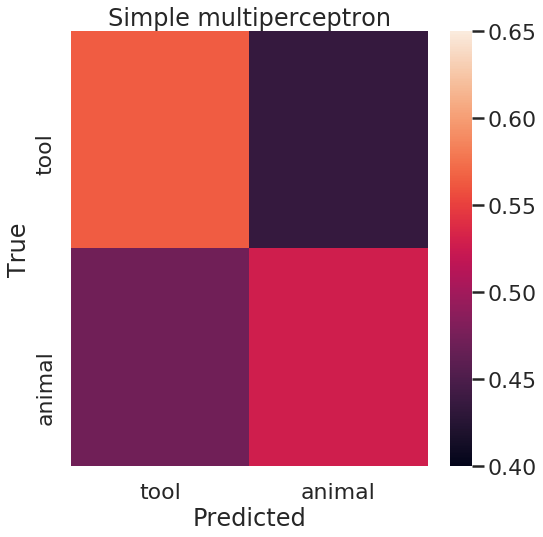

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm,ax=ax,vmin=0.4,vmax=0.65)
ax.set(ylabel = 'True', xlabel = 'Predicted',title = 'Simple multiperceptron')

# As we have shown that the model works well by a 30-fold cross-validation, we can investigate the model with the full data

In [0]:
full_data = MinMaxScaler().fit_transform(dataset.samples.astype('float32'))
full_labels = np.array([label_map[item] for item in dataset.sa.targets])

# The same way of initializing the model

In [18]:
classifier = clf(
                      shape, # input shape
                      dropout_rate          = 0.1, # drop out rate for each hidden layer
                      beta                  = 0, # for sparsity
                      lamda                 = 0, # for model simplicity
                      lr                    = 1e-4, # learning rate
                      decay                 = 1e-9, # schedule decay of the learning rate 
                      latent_dim            = 36, # latent space dimensionality 
                      )
vae_model_name   = 'classifier.{}.{}.hdf5'.format(
                                sub_name,
                                'combine',
                                ) # temporal model name 
# we will need 2 call back functions: 1) in-train saving and 2) early stopping
callBackList = make_CallBackList(vae_model_name,
                                       monitor                      = 'val_categorical_accuracy', # metric I care
                                       mode                         = 'max', # how I care
                                       verbose                      = 0,# print out the process
                                       min_delta                    = 1e-5,# how much difference it should make
                                       patience                     = patience[0], # early stop argument
                                       frequency                    = 1
                                       )
# first, feed the classifier with 0s, and see what the raw-raw gradient values are
# a trick I learned from twitter
print('initial loss {:.4f}'.format(classifier.evaluate(np.zeros(full_data.shape),
                                                        np.ones((full_data.shape[0],2)),
                                                        batch_size  = batch_size,
                                                        verbose     = 0
                                                        )[0]
                                    )
    )

initial loss 1.4034


# The same way of splitting the data to training and validation, and optimizing the classifier. Here, we don't have testing data

In [19]:
blocks,block_labels = get_blocks(dataset,label_map)
cv = StratifiedShuffleSplit(n_splits=2,test_size=0.2,random_state=12345)
for z,(training,validation) in enumerate(cv.split(blocks,block_labels)):
    idx_training    = np.concatenate([blocks[tr_el][-1] for tr_el in training])
    idx_validation  = np.concatenate([blocks[te_el][-1] for te_el in validation])
    print('classifier loss starts with {:.4f}'.format(classifier.evaluate(
                                          full_data,
                                          full_labels,
                                          batch_size                    = batch_size,
                                          verbose                       = 0
                                                                  )[0]))
    # fit the autoencoder with train data, and validate with validation data
    # remember the callbacks? That is why we need validation data
    # if the validation loss goes down, we save the model weights for that moment
    # if the validation loss don't go down for a couple epochs, we stop training
    history                 = classifier.fit(  
                                full_data[idx_training],
                                full_labels[idx_training],# input, output
                                batch_size                              = batch_size,# min batch size
                                epochs                                  = epochs,# just lots of epochs
                                validation_data                         = (full_data[idx_validation],full_labels[idx_validation]),# split the last 10% of the data as the validation data
                                verbose                                 = print_train,# print out the process
                                callbacks                               = callBackList # call back functions
                                )
#   K.set_value(autoencoder.optimizer.lr,(K.get_value(autoencoder.optimizer.lr)/10).round(6))
    classifier.load_weights(vae_model_name) # load the saved best model weights
    # let's look at the current model loss with all the training + validation data combined
    training_loss = classifier.evaluate(full_data,full_labels,
                                         batch_size                     = batch_size,
                                         verbose                        = 0
                                         )
    print('autoencoder loss = {:.4f},{} = {:.4f}'.format(training_loss[0],
          classifier.metrics_names[-1],
          training_loss[-1]))

classifier loss starts with 0.6985
autoencoder loss = 0.3001,categorical_accuracy = 0.9074
classifier loss starts with 0.3001
autoencoder loss = 0.1812,categorical_accuracy = 0.9663


# Let's plot the training

In [0]:
import matplotlib.pyplot as plt
from math import pi

[Text(0,0.5,u'Accuracy'), Text(0.5,0,u'Epochs')]

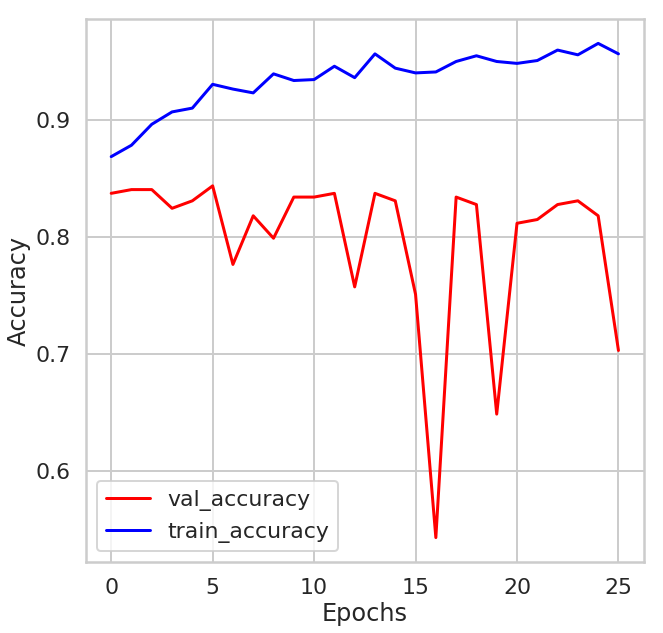

In [21]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(history.history['val_categorical_accuracy'],color='red',label='val_accuracy')
ax.plot(history.history['categorical_accuracy'],color='blue',label='train_accuracy')
ax.legend()
ax.set(xlabel='Epochs',ylabel='Accuracy')

[Text(0,0.5,u'Loss'), Text(0.5,0,u'Epochs')]

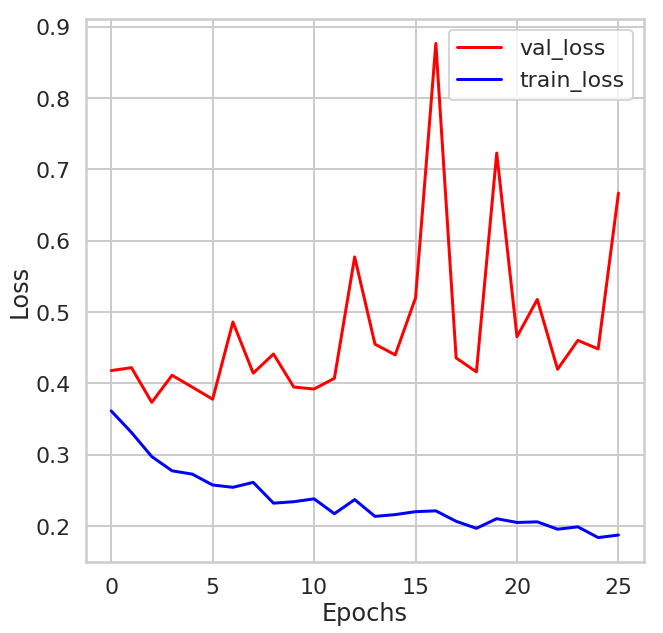

In [22]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(history.history['val_loss'],color='red',label='val_loss')
ax.plot(history.history['loss'],color='blue',label='train_loss')
ax.legend()
ax.set(xlabel='Epochs',ylabel='Loss')

# Make a function to output the hidden layer activations of the classifier. 
# I am doing this because I hypothesize that the supervised machine learning procedure benefits the model to learn something very useful, especially I on purposely design the hidden layer contains the same neurons as the number of the unique words used in the model. Thus, the model might learn the individual words

In [0]:
feature_selector = K.function([classifier.layers[0].input],
                                          [classifier.layers[-2].output])

# Get the activation of each instance,
# no averaging performed

In [24]:
latent_space = feature_selector([full_data])[0]
latent_space.shape

(1544, 36)

# Let's plot the hidden space

In [0]:
N = 36
angles = [n / float(N) * 2. * pi for n in range(N)]
angles += angles[:1]


Text(0.5,1.05,u'hidden representation\nOne subject\nred = tool, blue = animal')

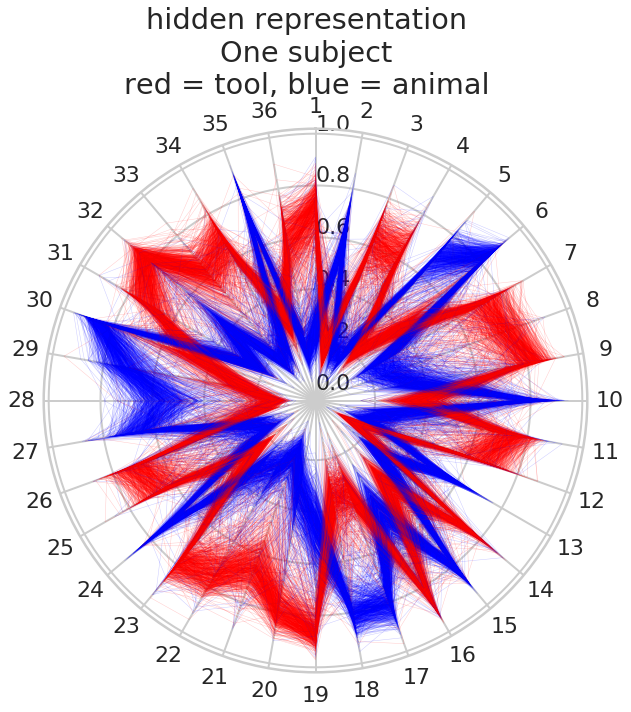

In [26]:
color = ['red','blue']
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,polar = True)
_=ax.set_theta_offset(pi / 2)
_=ax.set_theta_direction(-1)

_=ax.set(xticks = angles[:-1],xticklabels=['{}'.format(n+1) for n in range(N)])

ax.set_rlabel_position(0)
for row,label in zip(latent_space,full_labels[:,-1]):
    values = list(row)
    values += values[:1]
    ax.plot(angles,values,linewidth=0.5,alpha=0.2,color=color[label])
fig.suptitle('hidden representation\nOne subject\nred = tool, blue = animal',y = 1.05)

One of the problems interpreting the figure above is that the learning is not structured in order, therefore, we cannot interpret which neuron corresponds to which word

# find a set of input voxel values that maximize either the living word class or the non-living word class

In [0]:
###############################################################################################################################
###############################################################################################################################
############################# this block is directly from: ####################################################################
############################ https://github.com/thuijskens/bayesian-optimization ##############################################
###############################################################################################################################
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement
    Expected improvement acquisition function.
    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.
    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter
    Proposes the next hyperparameter to sample the loss function for.
    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.
    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation
    Uses Gaussian Processes to optimise the loss function `sample_loss`.
    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=False)

    for n in tqdm(range(n_iters),desc='Bayesian optimization'):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, 
                                                     model, 
                                                     yp, 
                                                     greater_is_better=True, 
                                                     bounds=bounds, 
                                                     n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################



In [28]:
n_iters                  = 5 # interations for the Bayesian optimization - cannot show more than 5 iterations
n_random_search          = int(1e4) # number of random search
n_pre_samples            = 10 # number of random looking before the optimization
found_input = {}
for target_objective in [0,1]:
    def sample_loss(input_voxel):
        target  = target_objective
        outputs = classifier.predict(input_voxel.reshape(1,-1))[:,-1]
        diff    = np.sqrt(np.sum((outputs[0] - target)**2))
        return diff
    bounds      = np.tile((0,1),dataset.shape[1]).reshape(-1,2)
    # with these hyperparameters, the bayesian optimization is to use a random search fashion to find a set of input
    # voxel values that maximize the probabilistic prediction of one of the classes
    # I did not choose to use scipy.optimize.minimize was because it is not only too slow and also not able to minimize
    # the loss function at all.
    # Due to the fact that there are 16,000 values to be optimized simultaneously, we better to have a more clever way to
    # process the optimization
    xp,yp       = bayesian_optimisation(      n_iters               = n_iters,# number of iteration of the optimization
                                              sample_loss           = sample_loss, # the loss function
                                              bounds                = bounds, # bounds of the optimized input values
                                              n_pre_samples         = n_pre_samples, # number of inputs to explore before the real optimization begines
                                              random_search         = n_random_search # number of random search during each iteration
                                              )
    x           = xp[np.argmin(yp)] # pick the one that returns the lowest loss value
    pred_       = classifier.predict(x.reshape(1,-1))# check the prediction of the optimized voxel values
    print('target: {}, maximum probability = {:.4f}-{:.4f}'.format({0:'tool',1:'animal'}[target_objective],
                                                            pred_[0,0],pred_[0,-1]))
    found_input[{0:'tool',1:'animal'}[target_objective]] = x

Bayesian optimization:   0%|          | 0/5 [00:00<?, ?it/s]

target: tool, maximum probability = 0.9164-0.0836


Bayesian optimization: 100%|██████████| 5/5 [00:29<00:00,  6.04s/it]

target: animal, maximum probability = 0.1262-0.8738


As shown above, we found a fMRI voxel values that 91.64% being a tool word, and a fMRI voxel values that 87.38% being an animal word.

# Now, we will look for ways to visualize these found "fMRI" scans

array([0.58263811, 0.74162481, 0.69945816, ..., 0.98399911, 0.91147631,
       0.85757466])